# Louis Long Notebook

### Emil studid & Louis studid, teamname 

#### Table of contents:
1. Exploratory data analysis
2. Models/Predictors
    - Model 1
    - Model 2
    - model ...
3. Feature Engineering 
    - Lime
    - feature importance
    - PDP
4. Model Interpretations
5. Improved models (possibly)



# ___________ _0. Setup_ ___________

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.ensemble as ensemble
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from pandas_profiling import ProfileReport

In [2]:
def writeResultToFile(test_data, pred_data, nameOfFile='namelessSubmission'):
    submission = pd.DataFrame()
    submission['id'] = test_data['store_id']
    submission['predicted'] = np.asarray(pred_data)
    submission.to_csv('submissionFiles/'+ nameOfFile+'.csv', index=False)
    

In [3]:
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred)**0.5

# ___________ _1. Exploratory Data Analysis_ ___________


### EDA Notes
- [ ] Search domain knowledge
- [ ] Check if the data is intuitive
- [ ] Understand how the data was generated
- [ ] Explore individual features
    - [x] Agencies
    - [x] stores with 0 revenue
    - [x] food and drink stores and grovery stores
- [ ] Explore pairs and groups
    - [x] Store type vs revenue
- [ ] Clean up features
    - [x] remove 2016
    - [x] remove outliers
    - [x] remove 0 revenue rows


In [4]:
stores_train = pd.read_csv('data/stores_train.csv')


In [ ]:
stores_train.head()

In [ ]:
stores_train.info()

In [ ]:
stores_train.describe()

In [ ]:
#report = ProfileReport(stores_train)
#report

Explore revenue based on store type

In [ ]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

In [ ]:
plt.figure(figsize=(20,6))
plt.gcf().set_dpi(600)
plt.xticks(rotation=90)
sns.violinplot(x='lv2_desc',y='revenue',data=stores_with_hierarchy).set_title("Revenue on store type")
plt.show()

further exploration of agencie store type

In [ ]:
stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Agencies"]

Further exploration of "Food and drink" type stores


In [ ]:
plt.figure(figsize=(10,5))
sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Food and drinks"]).set_title("Food and drinks violin plot")
plt.xticks(rotation=90)
plt.show()

Explore retailers with 0 revenue

In [ ]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]==0.0].describe()

All retailers and their cooresponding revenue, the plot is to visually check for outliers, clearly there are som outliers as can be seen in the plot below

In [ ]:
plt.plot(stores_train['store_id'], stores_train['revenue'],'o')
plt.figure(figsize=(30,5))
plt.show()

### Cleaning

#### Remove columns function - example: year is a const value and has no effect on the end result

In [14]:
def remove_columns(dataSet, columns):
    for column in columns:
        dataSet.drop(column, axis=1, inplace=True)


In [15]:
remove_columns(stores_train,['year'])
stores_train.head()

,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
0,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998
1,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828
2,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099
3,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296
4,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528


#### Remove retailers with 0 revenue function - might be handy

In [29]:
def remove_retailers_with_0_revenue(dataSet):
    dataSet.drop(dataSet[dataSet['revenue']==0.0].index, inplace=True)

In [ ]:
#remove_retailers_with_0_revenue(stores_train)

#### Removing outliers

Plotting all retailers based on storetype before and after trimming to confirm that outliers actually has been removed

In [ ]:
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()

Remove-outliers-function for the relationship between store type and revenue

In [144]:
def quantile_storeType_vs_revenue(stores, lower, upper):
    for store_type in stores['plaace_hierarchy_id'].unique():
        data = stores[stores['plaace_hierarchy_id']==store_type]
        upper_treshold = data['revenue'].quantile(upper)
        lower_treshold = data['revenue'].quantile(lower)
        stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index, inplace=True)
        stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index, inplace=True)
    

In [143]:
quantile_storeType_vs_revenue(stores_train)

TypeError: quantile_storeType_vs_revenue() missing 2 required positional arguments: 'lower' and 'upper'

Plot after removing outliers

you can see in the plot below that the outliers has been removed


In [ ]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()

#### comparing test set to training set

In [13]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

comparing coordinates

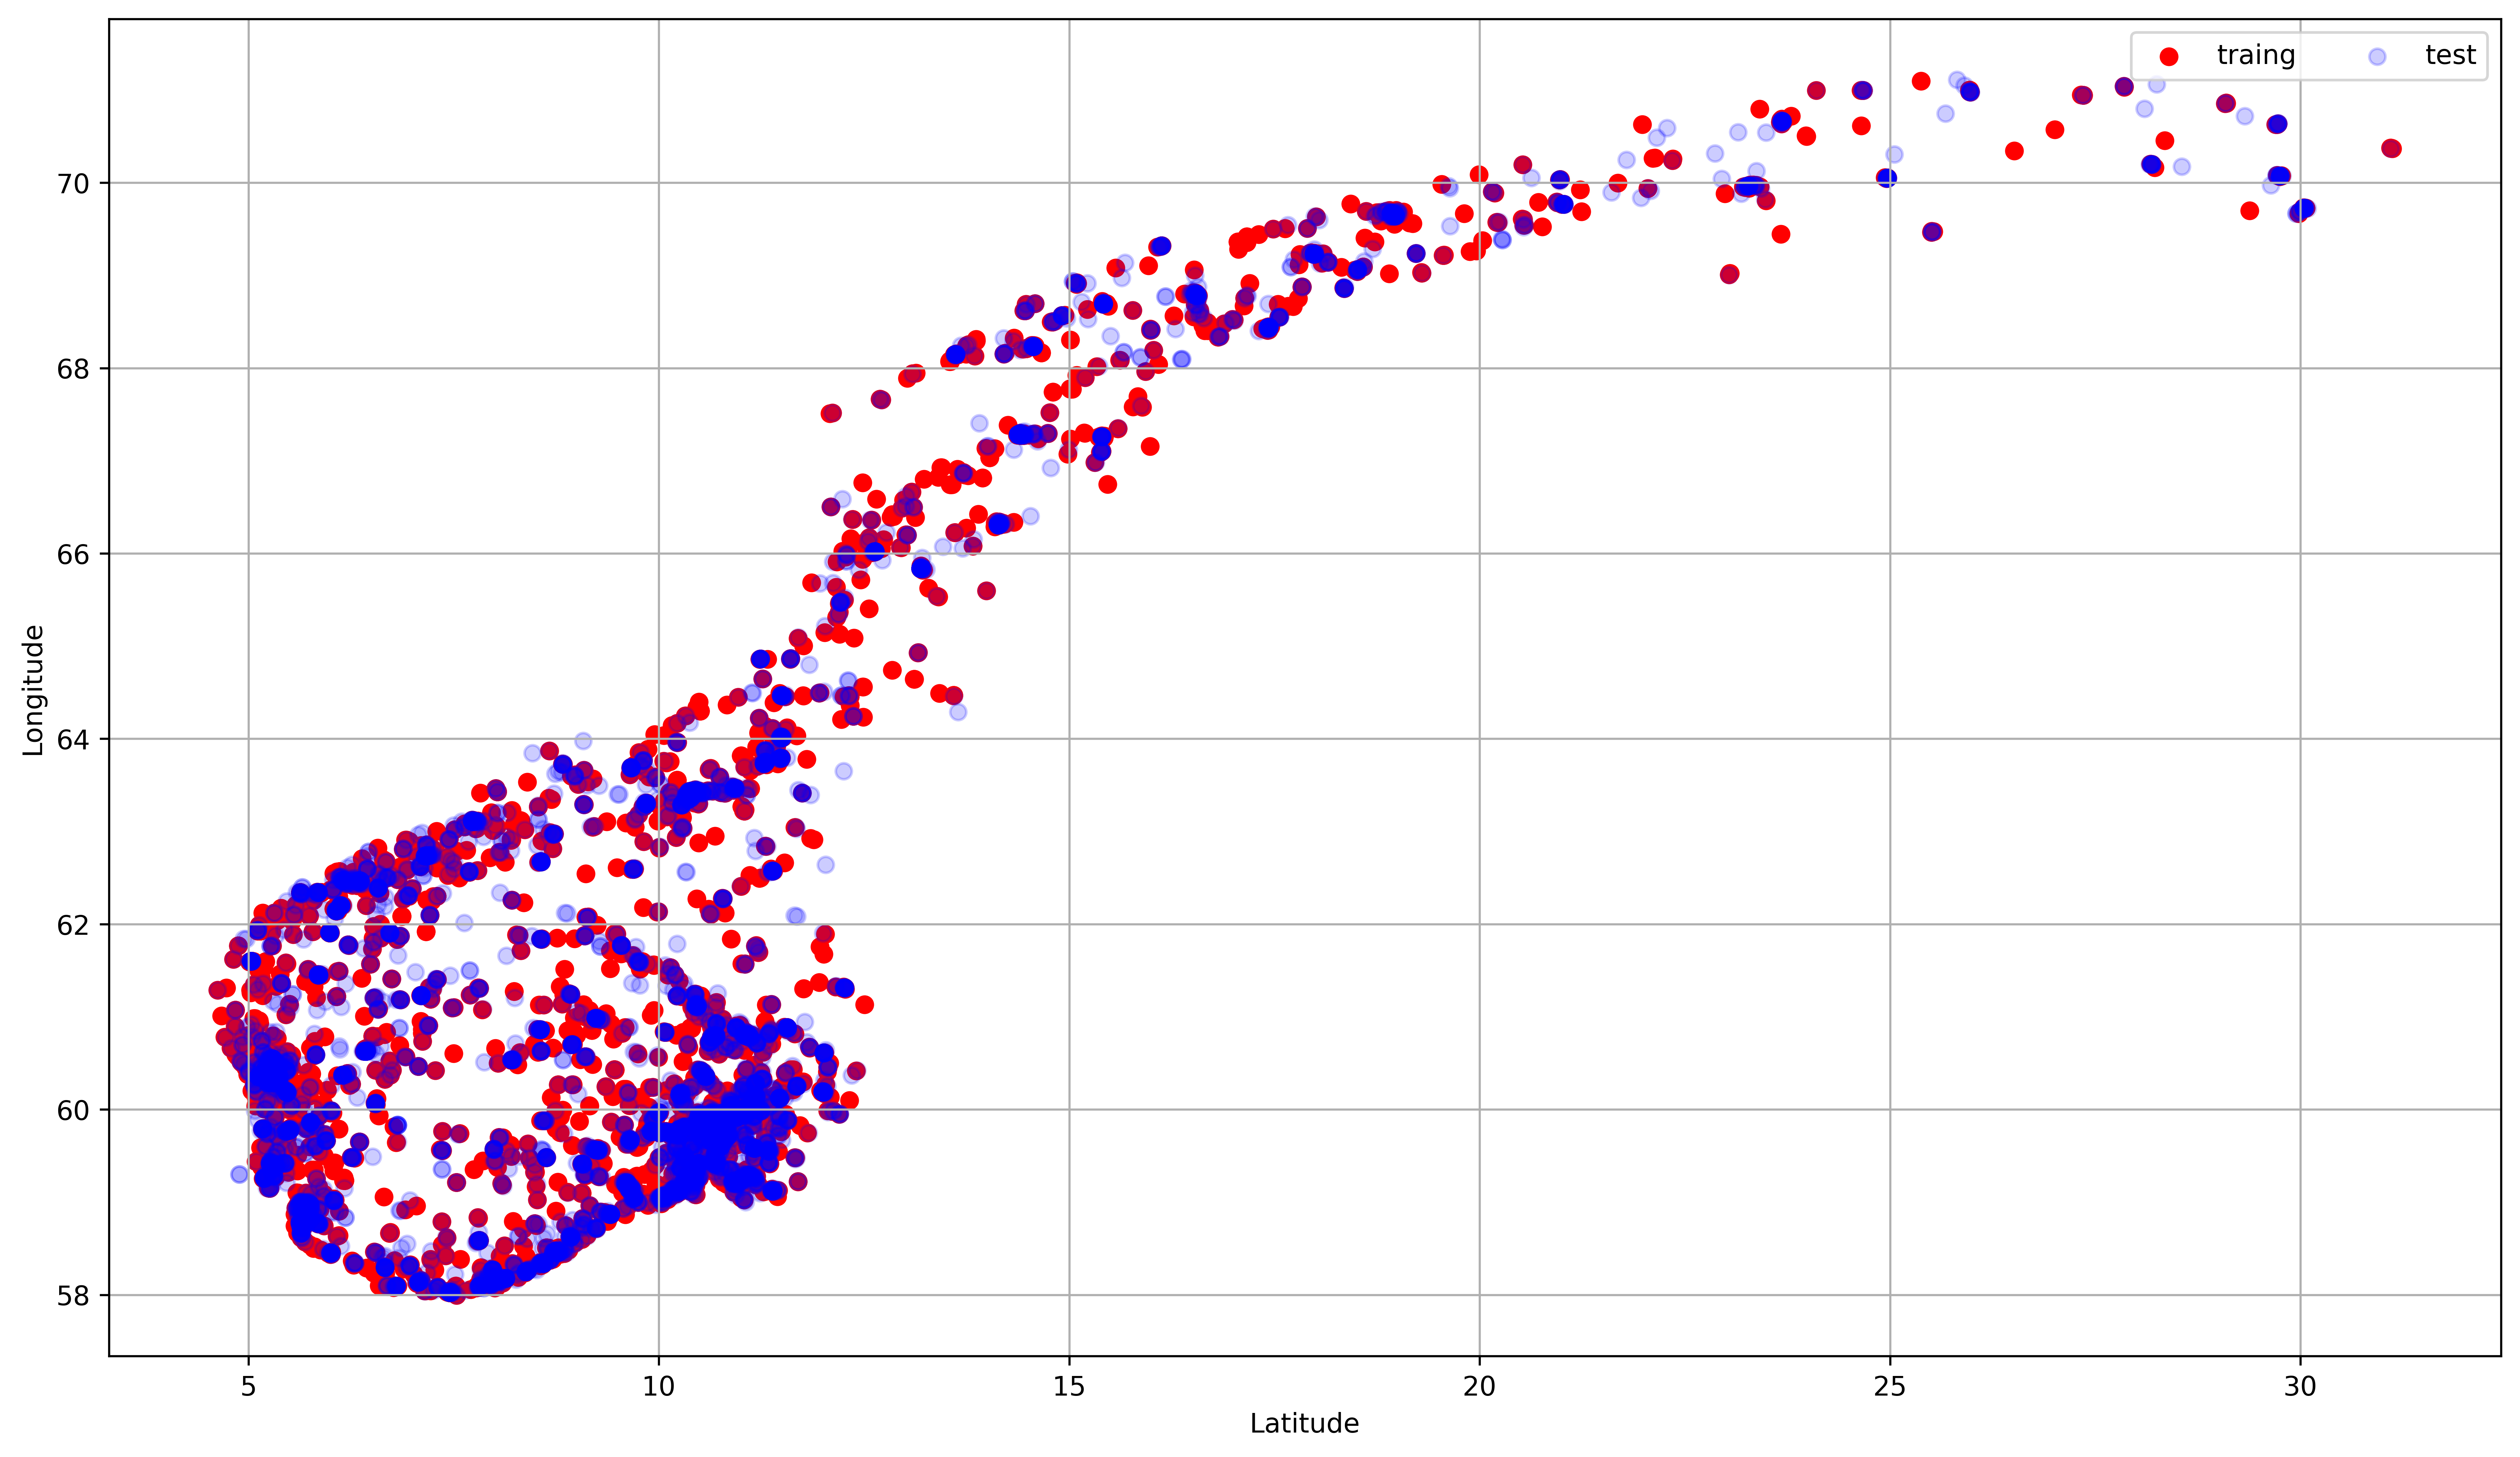

In [157]:
plt.figure(figsize=(16,9), dpi=600)
plt.scatter(stores_train['lon'],stores_train['lat'], label="traing",color='red')
plt.scatter(stores_test['lon'], stores_test['lat'], alpha=0.2, label="test", color="blue")
plt.legend(fontsize=10,ncol=2)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.show()



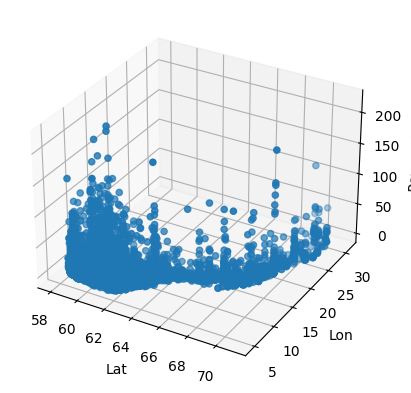

In [148]:
fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(stores_train['lat'],stores_train['lon'],stores_train['revenue'])
ax1.set_xlabel('Lat')
ax1.set_ylabel('Lon')
ax1.set_zlabel('Revenue')
plt.show()


#### Examine whether a store occurs in multiple datasets 

In [140]:
def stores_that_are_in_both_sets(df1, df2):
    
    duplicate_set = pd.merge(df1,df2, how='inner', on='store_id')
    return duplicate_set

stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_extra = pd.read_csv('data/stores_extra.csv')

dup = stores_that_are_in_both_sets(stores_extra, stores_train)
dup

,store_id,year_x,store_name_x,plaace_hierarchy_id_x,sales_channel_name_x,grunnkrets_id_x,address_x,lat_x,lon_x,chain_name_x,...,store_name_y,plaace_hierarchy_id_y,sales_channel_name_y,grunnkrets_id_y,address_y,lat_y,lon_y,chain_name_y,mall_name_y,revenue


#

# 2.___________ _Machine Learning Models and Predictions_ ___________


## Louis modeller

## _____ LightGBM _____

Helper functions

In [158]:
def convert_DType_LGBM(dFrame):
    X = pd.DataFrame()
    for col_name in dFrame:
        if dFrame[col_name].dtypes == 'object':
            X[col_name] = dFrame[col_name].astype('category')
        else:
            X[col_name] = dFrame[col_name]
    
    return X


In [230]:
stores_train = pd.read_csv('data/stores_train.csv')

# select prefered columns
remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','grunnkrets_id','address'])

# Divide data into train and test set
temp_x = stores_train.drop('revenue', axis=1)
temp_y = stores_train['revenue']

_, x_test, _, y_true = train_test_split(temp_x, temp_y, test_size=0.20, random_state=1)


# Preprocess/Clean data
quantile_storeType_vs_revenue(stores_train,0.10, 0.80)
#remove_retailers_with_0_revenue(stores_train)

# Divide data into x and y train, and test data for submission
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']


# Convert from object type to numerical
x_train = convert_DType_LGBM(x_train)
x_test = convert_DType_LGBM(x_test)

In [231]:
x_test.head()

,plaace_hierarchy_id,lat,lon,chain_name,mall_name
7171,2.8.1.0,59.737597,10.207078,NaN,NaN
5164,2.4.6.0,59.264405,5.192721,NaN,Amfi Åkrehamn
3158,2.1.1.0,59.096753,9.053424,NaN,NaN
4234,2.3.1.0,69.720500,30.038844,ELKJØP NORGE,NaN
4566,2.4.2.0,70.981458,25.974303,NaN,NaN


Make model and train

In [232]:
# Model
LGBM = lgb.LGBMRegressor()

# fitting
LGBM.fit(x_train, y_train)


LGBMRegressor()

Test LightGBM

In [233]:
# predicting the training data set as a pin pointer
pred = LGBM.predict(x_test)
for i in range(len(pred)):
    if pred[i] < 0.0:
        print(i)
        pred[i] = 0.0
print(rmsle(y_true,pred))

1711
1984
2124
0.7662267961823811


Autotesting percentile cut

In [247]:
for i in range(0,10,1):
    stores_train = pd.read_csv('data/stores_train.csv')

    # select prefered columns
    remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','grunnkrets_id','address'])

    # Divide data into train and test set
    temp_x = stores_train.drop('revenue', axis=1)
    temp_y = stores_train['revenue']

    _, x_test, _, y_true = train_test_split(temp_x, temp_y, test_size=0.20, random_state=2)


    # Preprocess/Clean data
    quantile_storeType_vs_revenue(stores_train,i*0.01, 0.86)
    #remove_retailers_with_0_revenue(stores_train)

    # Divide data into x and y train, and test data for submission
    x_train = stores_train.drop('revenue', axis=1)
    y_train = stores_train['revenue']


    # Convert from object type to numerical
    x_train = convert_DType_LGBM(x_train)
    x_test = convert_DType_LGBM(x_test)
    # Model
    LGBM = lgb.LGBMRegressor()

    # fitting
    LGBM.fit(x_train, y_train)
    # predicting the test data
    pred = LGBM.predict(x_test)
    for j in range(len(pred)):
        if pred[j] < 0.0:
            pred[j] = 0.0
    print(f"for upper limit {round((i*0.01), 2)}, rmsle = {round(rmsle(y_true,pred), 4)}")

for upper limit 0.0, rmsle = 0.7459
for upper limit 0.01, rmsle = 0.7482
for upper limit 0.02, rmsle = 0.7484
for upper limit 0.03, rmsle = 0.7515
for upper limit 0.04, rmsle = 0.7527
for upper limit 0.05, rmsle = 0.7558
for upper limit 0.06, rmsle = 0.7583
for upper limit 0.07, rmsle = 0.7596
for upper limit 0.08, rmsle = 0.7642
for upper limit 0.09, rmsle = 0.7704


Predict test and submit

In [248]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
test = stores_test.copy()

# Preprocess/Clean data
remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','grunnkrets_id','address'])
remove_columns(test, ['store_id','year','store_name','sales_channel_name','grunnkrets_id','address'])
quantile_storeType_vs_revenue(stores_train,0.02, 0.86)
#remove_retailers_with_0_revenue(stores_train)

# Divide data into x and y train, and test data for submission
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']

# Convert from object type to numerical
x_train = convert_DType_LGBM(x_train)
test = convert_DType_LGBM(test)

# Model and fitting
LGBM = lgb.LGBMRegressor()
LGBM.fit(x_train, y_train)

# Predict test-data-set
pred_test_LGBM = LGBM.predict(test)

# remove negative values
for i in range(len(pred_test_LGBM)):
    if pred_test_LGBM[i] < 0.0:
        print(i)
        pred_test_LGBM[i] = 0.0



1169
1269
1284
1305
1309
1313
1424
1463


In [249]:
#write the predicition to file
writeResultToFile(stores_test, pred_test_LGBM, "LGBM_02_86_precentile_storeType_lat_long_chain_mall_plaace_hier_id")

# Verify format of submission file
submissionVery = pd.read_csv('submissionFiles/LGBM_02_86_precentile_storeType_lat_long_chain_mall_plaace_hier_id.csv')
submissionVery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8577 entries, 0 to 8576
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         8577 non-null   object 
 1   predicted  8577 non-null   float64
dtypes: float64(1), object(1)
memory usage: 134.1+ KB


## _____ Random Forest Regressor _____

Load, preprocess and convert data to correct format

In [101]:
# Load training and test data
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

# Preprocess/Clean data
remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])
remove_columns(stores_test, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])
#remove_retailers_with_0_revenue(stores_train)
quantile_storeType_vs_revenue(stores_train,0.10, 0.80)

# Divide data into x and y train
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']
x_test = stores_test.copy()

# Convert from object type to numerical
#train set
cat_columns = x_train.select_dtypes(['object']).columns
x_train[cat_columns] = x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])
#test set
cat_columns = x_test.select_dtypes(['object']).columns
x_test[cat_columns] = x_test[cat_columns].apply(lambda x: pd.factorize(x)[0])



In [104]:
stores_train.head()

,plaace_hierarchy_id,grunnkrets_id,lat,lon,revenue
2,1.1.1.0,6050102,60.164751,10.254656,16.099
3,1.1.1.0,18040102,67.283669,14.379796,9.296
4,1.1.1.0,16017414,63.358068,10.374832,4.528
5,1.1.1.0,11030509,58.970249,5.731728,12.020
6,1.1.1.0,18050706,68.438025,17.422916,7.622


Train model

In [102]:
# Model
RFR = RandomForestRegressor(n_estimators=100)

# Fitting
RFR.fit(x_train, y_train)


RandomForestRegressor()

Test RFR model

In [103]:
# predicting the training data set as a pin pointer
pred_train_RFR = RFR.predict(x_train)
print(rmsle(y_train, pred_train_RFR))
print(RFR.score(x_train, y_train))

0.24556789244111218
0.9223635512553297


Predict test and submit

In [100]:
pred_test_RFR = RFR.predict(x_test)

In [ ]:
# Write to file
writeResultToFile(stores_test, pred_test_RFR, "RFR_10_80_percentile")

# Verify format of submission file
submissionVery = pd.read_csv('submissionFiles/RFR_10_80_percentile.csv')
submissionVery.info()

## Emil modeller

### model 1


In [ ]:
# pythons stuff emil

# 3. Feature Engineering

### some feature moding

In [ ]:
#modding data....

# 4. Model Interpretations

### Lime

In [ ]:
#lime stuff in python

### Feature importance

In [ ]:
#feature importance

### PDP

In [ ]:
#PDP

# 5. Final improved models/predictions

### model 1

In [ ]:
#final model 1

### model 2

In [ ]:
#final model 2

# Testing


### RMSLE

In [ ]:
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred)**0.5
